In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings

from Bio import Phylo
import math
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

# sklearn
from sklearn import metrics

warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNSD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/HNSD_mini/outdir/sc_bulk_BCR_data_analysis_v0.1"

PROJECT = "220701_etc_biopsies"
path_to_main_output = f"{outdir}/tree_analysis/{PROJECT}"
path_to_01_output = os.path.join(path_to_main_output, "01_output")
os.system(f"mkdir -p {path_to_01_output}")

output_type = "mouse_based_output"

path_to_trees = os.path.join(path_to_storage, PROJECT, "GCtrees/v0.2", output_type)

all_tree_folder = [item for item in pathlib.Path(path_to_trees).glob("*") if 
                   os.path.isfile(f"{str(item)}/02_dnapars/gctree.out.inference.1.nk") == True]

all_nk_files = {all_tree_folder[i].name: os.path.join(all_tree_folder[i], "02_dnapars", "gctree.out.inference.1.nk") for i in range(len(all_tree_folder))}
print(f"Number of trees: {len(all_tree_folder)}")   

path_to_metadata = "/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/220701_etc_biopsies/metadata.csv"
mid_metadata = pd.read_csv(path_to_metadata, sep =";")

##### Re run the summary analysis of all trees and rendering tree figures
# rerun = True
rerun = False

path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85

clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]
clonedf = clonedf[clonedf['dataset.name'] == "220701_etc_biopsies"]

maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")
    # Reload the dictionary from the pickle file
with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)

color_path = "./hex_color.csv"

/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of trees: 7618


In [43]:
##### analysis example for 1 tree. 

show_plot = True
# cloneid = "m30_IGHV1-82-01_IGHJ2-01_30_1.aln"
cloneid = "m11_IGHV1-15*01_IGHJ1*03_48_1.aln".replace("*", "-")
mouseid = cloneid.split("_")[0]
path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
os.system(f"mkdir -p {path_to_save_tree_svg}")

treeobj = saveTreeobj[cloneid] 
avai_mids = treeobj.seqdf["MID"].unique()
mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

ts = treeobj.generate_tree_style(color_path = color_path)

for input_mid in avai_mids:
    if input_mid == "GL":
        input_mid_col = "gray"
    else:
        input_mid_col = mid_color_pal[input_mid]
    ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
    ts.legend.add_face(TextFace(mid_metadata[mid_metadata["Unnamed: 0"]==input_mid]["population"].values[0]), column = 0)

idmapdf = treeobj.idmapseqdf.copy()
seqdf = treeobj.seqdf.copy()
seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["Unnamed: 0"] == x]["population"].values[0])
seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
if show_plot:
    treeobj.tree.render(f"%%inline", tree_style=ts)


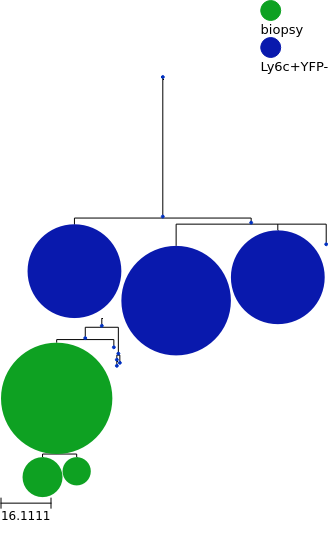

In [44]:
treeobj.tree.render(f"%%inline", tree_style=ts)

In [ ]:
show_plot = False
all_rand_idxs = []
for cloneid in tqdm(saveTreeobj.keys()):
    treeobj = saveTreeobj[cloneid]
    cluster_resolution = 1

    tree_rand_index = treeobj.cluster_samples_on_branches(
        show_plot = show_plot,
        cluster_resolution = cluster_resolution
    )
    all_rand_idxs.append(tree_rand_index)

randdf = pd.DataFrame.from_dict(
    {
        "cloneID": saveTreeobj.keys(),
        f"rand_index_{cluster_resolution}": all_rand_idxs
    }
)

100%|██████████| 7618/7618 [02:19<00:00, 54.54it/s]


In [45]:
randdf

,cloneID,rand_index_1
0,m31_IGHV14-3-01_IGHJ1-03_42_1.aln,1.000000
1,m43_IGHV3-6-01_IGHJ2-01_42_2.aln,0.500000
2,m12_IGHV1-58-01_IGHJ2-01_33_2.aln,1.000000
3,m31_IGHV1-59-01_IGHJ3-01_36_5.aln,1.000000
4,m39_IGHV1-72-01_IGHJ2-01_39_6.aln,0.333333
...,...,...
7613,m30_IGHV1-64-01_IGHJ4-01_42_1.aln,1.000000
7614,m30_IGHV3-6-01_IGHJ3-01_24_1.aln,0.333333
7615,m32_IGHV6-3-01_IGHJ3-01_44_2.aln,0.200000
7616,m37_IGHV1-26-01_IGHJ3-01_42_5.aln,1.000000
